# **此程式為基因演算法(GA)應用實作**     
### **嘗試求解工作指派問題(Job Assignment Problem)**
----------------
* ## **GA的過程**
### **有點物競天擇的概念，個人找了張比較可愛的圖:**
<img src="GA_process.png" alt="drawing" width="500"/></img>
##### **圖源:https://www.generativedesign.org/02-deeper-dive/02-04_genetic-algorithms/02-04-01_what-is-a-genetic-algorithm**

### **通常步驟循環如下:**
#### **1. Initialization (generation) : 產生物種**
#### **2. Evaluation (of each individual) : 評估優劣 (計算fitness)**
#### **3. Selection : 選擇 (從上一代選出較佳的個體)。 採菁英挑選法，選擇fitness較好的前幾名**
#### **4. Crossover (reproduction) : 交配。 隨機選擇一切點，將兩染色體的被切開的位置互相交換**
#### **5. mutation : 突變。 隨機選取染色體的位元，將此位元做0與1互換。**
------------------

* ## **實作**

In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from codecs import decode
from functools import reduce  
import struct
import random
import math
import matplotlib.pyplot as plt

### **假設有8台機器，每台機器處理各項工作的時間不一，產生表格如下:**

In [2]:
#產生假資料
data = []
for i in range(8):
    productivity = []
    for j in range(8):
        productivity.append(round(np.random.uniform(20,50),2))
    data.append(productivity)
    
df=pd.DataFrame(data)
df.columns= ["Machine1","Machine2","Machine3","Machine4","Machine5","Machine6","Machine7","Machine8"]
df.index= ["Job1","Job2","Job3","Job4","Job5","Job6","Job7","Job8"]
df

,Machine1,Machine2,Machine3,Machine4,Machine5,Machine6,Machine7,Machine8
Job1,29.12,25.14,39.30,43.41,38.66,33.53,44.37,40.58
Job2,21.43,21.26,26.47,36.55,34.20,29.72,23.22,45.96
Job3,42.70,21.16,43.97,32.42,26.61,22.42,42.55,20.57
Job4,27.27,49.92,20.90,21.13,36.14,46.55,44.47,22.60
Job5,42.53,30.25,26.48,48.90,49.42,20.15,36.28,39.40
Job6,26.32,33.88,20.34,40.07,36.88,43.68,49.75,36.70
Job7,24.23,31.61,41.12,46.46,38.32,25.21,43.87,49.64
Job8,45.58,41.18,31.75,46.76,23.03,43.55,20.55,21.30



## **試問: 應該將每項 Job 分配給哪台 Machine ，使得總花費時間最少?**
* #### **假設結果為 [1, 4, 3, 5, 7, 6, 8, 2] ，表示 Job1 分配給第1台機器、Job2 給第4台，以此類推....**
------------------

* ### **前置作業**
> #### **因為模擬基因演化，每一項數值資料會被轉變成像是染色體的形式，方便進行交配與突變**
> #### **如下圖紅線範圍互換，可產生兩個不同個體:**
<img src="binary_crossover.jpg" alt="drawing" width="700"></img>
>##### **圖源:https://www.tutorialspoint.com/genetic_algorithms/genetic_algorithms_crossover.htm**

* #### **寫個轉換法測試看看**

In [3]:
#def float_to_bin(num):
    #return bin(struct.unpack('!I', struct.pack('!f', num))[0])[2:].zfill(32)
#def bin_to_float(binary):
    #return round(struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0],2)
def decimalToBinary(n):
    return bin(n).replace("0b","")    
def BinaryTodecimal(n):
    return reduce(lambda x, y: 2*x + y, map(int, n))  

In [4]:
print("原始值8, 二進位轉換->",decimalToBinary(8), ", 轉換回十進位->",BinaryTodecimal(decimalToBinary(8)))

原始值8, 二進位轉換-> 1000 , 轉換回十進位-> 8


### **<span style="color:red">但是!!!**</span>
### **<span style="color:red">此問題是整數解，且數值範圍固定、不可重複。 所以我想採用的方式:**</span>
### **亂數決定哪些基因特徵要保留下來，例如2, 4, 6​。其他特徵洗牌重分配**
<img src="crossover.jpg" alt="drawing" width="400"></img>
### **有點像保留父親特徵，其他特徵從媽媽來。 (但我個人覺得比較像無性生殖!)**
### **父親母親各做一次，所以一對夫妻會產生兩個子代~**

--------------------
### **參數介紹**
#### **N：population， 可以理解為每個世代的人口數量(固定不變，就算某些父母被淘汰，也會有新生兒加入)。**
#### **D：Dimension，  目標問題之變數數量。**
#### **B：Bits number，  解的大小受限於 bit 數的控制。(這裡不會用到)**
#### **n：Elite number，  天擇菁英個數。**
#### **cr：Crossover rate，  交配率。**
#### **mr：Mutation rate，  突變率。**
#### **max_iter: MaxIteration，  迭代次數**

In [5]:
class GA():
    
    def __init__(self,Population, Dim, Bitnum, Elite_num, CrossoverRate, MutationRate, MaxIteration):
        self.N = Population
        self.Dim = Dim
        self.B = Bitnum
        self.n = Elite_num
        self.cr = CrossoverRate
        self.mr = MutationRate
        self.max_iter = MaxIteration
        
    #隨機產生人口解
    def generatePopulation(self):
        population = []  
        for number in range(self.Dim):
            shuffle = [i for i in range(self.Dim)]
            random.seed(random.randint(1,1000))
            random.shuffle(shuffle)
            population.append(shuffle)
        return population

    #挑選菁英父母
    def Selection(self, n, pop_bin, fitness):
        Parents = []
        tempfitness=fitness
        temppop_bin=pop_bin
        
        for i in range(n):
            loc = fitness.index(min(tempfitness))
            Parents.append(pop_bin[loc])
            del temppop_bin[loc]
            del tempfitness[loc]
        return Parents
    
    #交配&突變
    def Crossover_Mutation(self, father, mother):

        child1=[]
        child2=[]

        #產生亂數，決定是否進行Crossover
        threshold = random.uniform(0,1)
        
        #決定交配
        if threshold < self.cr:   
            #決定要遺傳(保留)的基因個數
            cut_points = random.sample(range(self.Dim), 5)

            #Crossover
            locate1=[]
            locate2=[]
            for i in range(self.Dim):
                #記住爸爸基因位置
                if father[i] in cut_points:
                    locate1.append(i)
                #記住媽媽基因位置
                if mother[i] in cut_points:
                    locate2.append(i)
                    
            #全部的基因有這些
            all_gene=[i for i in range(self.Dim)]

            #除去要固定的基因後洗牌
            last_gene1=list(set(all_gene)-set(cut_points))
            last_gene2=list(set(all_gene)-set(cut_points))
            random.seed(random.randint(1,1000))
            random.shuffle(last_gene1)
            random.shuffle(last_gene2)

            #在原先位置補回父母的基因
            for i in locate1:
                last_gene1.insert(i,father[i])
            for i in locate2:
                last_gene2.insert(i,mother[i])
            child1=last_gene1
            child2=last_gene2 
            
            #隨機生成一數字，用以決定是否進行mutation          
            threshold2 = random.uniform(0,1)
            if threshold2 < self.mr:
                idx = range(ga.Dim)
                i1, i2 = random.sample(idx, 2)
                child1[i1], child1[i2] = child1[i2], child1[i1]
                child2[i1], child2[i2] = child2[i2], child2[i1]

        #不交配
        else:
            child1=father
            child2=mother
            #但仍考慮突變
            threshold2 = random.uniform(0,1)
            if threshold2 < self.mr:
                idx = range(ga.Dim)
                i1, i2 = random.sample(idx, 2)
                child1[i1], child1[i2] = child1[i2], child1[i1]
                child2[i1], child2[i2] = child2[i2], child2[i1]
                
        return child1,child2

In [6]:
def fitness(x):
    global data
    y=[]
    for i in range(len(x)):
        sum=0
        for j in range(len(x[i])):
            sum+=data[j][x[i][j]]
        y.append(round(sum,2))
    return y

In [7]:
ga=GA(15, #人口數量
      8,  #問題維度
      32, #二進位個數
      4,  # 菁英數量
      0.9, #交配率
      0.2, #突變率
      40, #迭代次數
     )

#產生第一代
decimal_population = ga.generatePopulation()

#初始化世代資訊
generation_fitness=fitness(decimal_population)
best_fitness = min(generation_fitness)
best_population = decimal_population[generation_fitness.index(best_fitness)]

#儲存歷史最佳用的
every_generation_fitness=[]
every_generation_bestfitness=[]
every_generation_fitness.append(best_fitness)
every_generation_bestfitness.append(best_fitness)
finial_population=[]

#為了進行交配，先把人口資料轉成二進位
#for i in range(len(decimal_population)):
    #binary_population.append([])
    #for j in range(len(decimal_population[i])):
        #binary_population[i].append(decimalToBinary(j))

#開始演化
it = 0
while it < ga.max_iter:
    
    #從人口中挑選當代的(菁英)亞當、夏娃
    #print(decimal_population)
    Parents= ga.Selection( ga.n, decimal_population, generation_fitness)
    
    #決定交配順序
    line = [i for i in range(len(Parents))]
    random.seed(random.randint(1,1000))
    random.shuffle(line)
    
    ##倆倆進行交配
    offspring=[] #後代
    for i in range(0,len(line),2):
        father = Parents[line[i]]
        mother = Parents[line[i+1]]
        childs = ga.Crossover_Mutation(father, mother)
        offspring.append(childs[0])
        offspring.append(childs[1])
        
    #得到此次演化的世代集合
    finial_population = Parents+offspring
    #將人口資料轉回十進位
    #final_dec = []
    #for i in range(ga.N):
        #temp = []
        #for j in range(ga.Dim):
            #temp.append(BinaryTodecimal(final_bin[i][j]))
        #final_dec.append(temp)

    # 評估優劣
    final_fitness = fitness(finial_population)

    #找出此回合最好的一代
    smallest_fitness = min(final_fitness)
    index = final_fitness.index(smallest_fitness)
    smallest_dec = finial_population[index]
    
    every_generation_fitness.append(smallest_fitness)

    #更新最佳世代
    if(smallest_fitness < best_fitness):
        best_fitness = smallest_fitness
        best_population = smallest_dec  
        every_generation_bestfitness.append(best_fitness)
    else:
        every_generation_bestfitness.append(best_fitness)
        
    #更新當前世代資訊以進入下一回演化
    decimal_population = finial_population
    generation_fitness = final_fitness
    
    it += 1

## **計算結果**

In [8]:
print("最短需花費時間:"+str(best_fitness))
print("工作分配狀況:", [i+1 for i in best_population])

最短需花費時間:205.04
工作分配狀況: [2, 5, 6, 4, 7, 3, 1, 8]


## **print each run fitness**

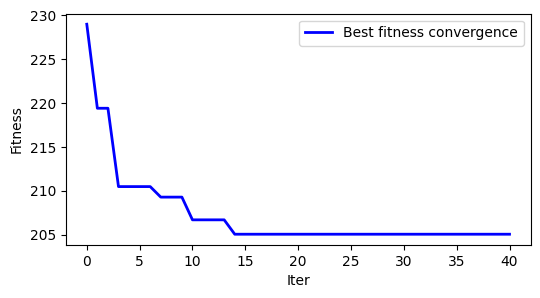

In [9]:
plt.figure(figsize = (6,3))
plt.xlabel("Iter",fontsize=10)
plt.ylabel("Fitness",fontsize=10)

plt.plot(every_generation_bestfitness,linewidth = 2, label = "Best fitness convergence", color = 'b')
plt.legend()
plt.show()